In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima_model import ARIMA
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

Настраиваем доступ к базе

In [71]:
from typing import Optional
from pymongo import MongoClient

MONGO_HOST = '127.0.0.1'
MONGO_PORT = 27020
MONGO_USERNAME = 'admin'
MONGO_PASSWORD = 'admin'


class DayCollection:
    def __init__(self, collection):
        self.collection = collection

    def get_all(self):
        return self.collection.find({})


class MongoManager:
    __instance: Optional[MongoClient] = None
    DB_NAME = 'evraza2'
    collection_by_day = 'records_{}_{}_{}'

    client: MongoClient = None

    def __init__(self):
        self.db = None

    def connect(self):
        self.client: MongoClient = MongoClient(
            MONGO_HOST, MONGO_PORT,
            username=MONGO_USERNAME,
            password=MONGO_PASSWORD
        )
        self.db = self.client[self.DB_NAME]

    def disconnect(self):
        self.client.close()

    def write_new_msg(self, document):
        pass

    def print_server_info(self):
        print(self.client.server_info())

    def get_client(self):
        return self.client

    def get_collection(self, day: int = 10, month: int = 2, year: int = 2023):
        return DayCollection(self.db[self.collection_by_day.format(day, month, year)])

получаем клиент

In [72]:
from collections import defaultdict

client = MongoManager()
client.connect()

Обработаем данные из базы, сложив точки в списки по метрикам

In [73]:
# скрипт, получающий маппинг, есть в коде бекенда
mapping = {"0": {"SM_Exgauster\\[2:27]": {"mock": "1"}, "SM_Exgauster\\[2:2]": {"mock": "1"}, "SM_Exgauster\\[2:0]": {"mock": "1"}, "SM_Exgauster\\[2:1]": {"mock": "1"}, "SM_Exgauster\\[2:28]": {"mock": "1"}, "SM_Exgauster\\[2:5]": {"mock": "1"}, "SM_Exgauster\\[2:3]": {"mock": "1"}, "SM_Exgauster\\[2:4]": {"mock": "1"}, "SM_Exgauster\\[2:29]": {"mock": "1"}, "SM_Exgauster\\[2:30]": {"mock": "1"}, "SM_Exgauster\\[2:31]": {"mock": "1"}, "SM_Exgauster\\[2:32]": {"mock": "1"}, "SM_Exgauster\\[2:33]": {"mock": "1"}, "SM_Exgauster\\[2:8]": {"mock": "1"}, "SM_Exgauster\\[2:6]": {"mock": "1"}, "SM_Exgauster\\[2:7]": {"mock": "1"}, "SM_Exgauster\\[2:34]": {"mock": "1"}, "SM_Exgauster\\[2:11]": {"mock": "1"}, "SM_Exgauster\\[2:9]": {"mock": "1"}, "SM_Exgauster\\[2:10]": {"mock": "1"}, "SM_Exgauster\\[2:35]": {"mock": "1"}, "SM_Exgauster\\[2:42]": {"mock": "1"}, "SM_Exgauster\\[2:37]": {"mock": "1"}, "SM_Exgauster\\[2:24]": {"mock": "1"}, "SM_Exgauster\\[4.1]": {"mock": "1"}, "SM_Exgauster\\[4:2]": {"mock": "1"}, "SM_Exgauster\\[4:0]": {"mock": "1"}, "SM_Exgauster\\[2.0]": {"mock": "1"}}, "1": {"SM_Exgauster\\[2:43]": {"mock": "1"}, "SM_Exgauster\\[2:14]": {"mock": "1"}, "SM_Exgauster\\[2:12]": {"mock": "1"}, "SM_Exgauster\\[2:13]": {"mock": "1"}, "SM_Exgauster\\[2:44]": {"mock": "1"}, "SM_Exgauster\\[2:17]": {"mock": "1"}, "SM_Exgauster\\[2:15]": {"mock": "1"}, "SM_Exgauster\\[2:16]": {"mock": "1"}, "SM_Exgauster\\[2:45]": {"mock": "1"}, "SM_Exgauster\\[2:47]": {"mock": "1"}, "SM_Exgauster\\[2:48]": {"mock": "1"}, "SM_Exgauster\\[2:49]": {"mock": "1"}, "SM_Exgauster\\[2:50]": {"mock": "1"}, "SM_Exgauster\\[2:20]": {"mock": "1"}, "SM_Exgauster\\[2:18]": {"mock": "1"}, "SM_Exgauster\\[2:19]": {"mock": "1"}, "SM_Exgauster\\[2:51]": {"mock": "1"}, "SM_Exgauster\\[2:23]": {"mock": "1"}, "SM_Exgauster\\[2:21]": {"mock": "1"}, "SM_Exgauster\\[2:22]": {"mock": "1"}, "SM_Exgauster\\[2:52]": {"mock": "1"}, "SM_Exgauster\\[2:60]": {"mock": "1"}, "SM_Exgauster\\[2:54]": {"mock": "1"}, "SM_Exgauster\\[2:25]": {"mock": "1"}, "SM_Exgauster\\[4.6]": {"mock": "1"}, "SM_Exgauster\\[4:9]": {"mock": "1"}, "SM_Exgauster\\[4:7]": {"mock": "1"}, "SM_Exgauster\\[2.1]": {"mock": "1"}}, "2": {"SM_Exgauster\\[0:27]": {"mock": "1"}, "SM_Exgauster\\[0:2]": {"mock": "1"}, "SM_Exgauster\\[0:0]": {"mock": "1"}, "SM_Exgauster\\[0:1]": {"mock": "1"}, "SM_Exgauster\\[0:28]": {"mock": "1"}, "SM_Exgauster\\[0:5]": {"mock": "1"}, "SM_Exgauster\\[0:3]": {"mock": "1"}, "SM_Exgauster\\[0:4]": {"mock": "1"}, "SM_Exgauster\\[0:29]": {"mock": "1"}, "SM_Exgauster\\[0:30]": {"mock": "1"}, "SM_Exgauster\\[0:31]": {"mock": "1"}, "SM_Exgauster\\[0:32]": {"mock": "1"}, "SM_Exgauster\\[0:33]": {"mock": "1"}, "SM_Exgauster\\[0:8]": {"mock": "1"}, "SM_Exgauster\\[0:6]": {"mock": "1"}, "SM_Exgauster\\[0:7]": {"mock": "1"}, "SM_Exgauster\\[0:34]": {"mock": "1"}, "SM_Exgauster\\[0:11]": {"mock": "1"}, "SM_Exgauster\\[0:9]": {"mock": "1"}, "SM_Exgauster\\[0:10]": {"mock": "1"}, "SM_Exgauster\\[0:35]": {"mock": "1"}, "SM_Exgauster\\[0:42]": {"mock": "1"}, "SM_Exgauster\\[0:37]": {"mock": "1"}, "SM_Exgauster\\[0:24]": {"mock": "1"}, "SM_Exgauster\\[1.1]": {"mock": "1"}, "SM_Exgauster\\[1:2]": {"mock": "1"}, "SM_Exgauster\\[1:0]": {"mock": "1"}, "SM_Exgauster\\[0.0]": {"mock": "1"}}, "3": {"SM_Exgauster\\[0:43]": {"mock": "1"}, "SM_Exgauster\\[0:14]": {"mock": "1"}, "SM_Exgauster\\[0:12]": {"mock": "1"}, "SM_Exgauster\\[0:13]": {"mock": "1"}, "SM_Exgauster\\[0:44]": {"mock": "1"}, "SM_Exgauster\\[0:17]": {"mock": "1"}, "SM_Exgauster\\[0:15]": {"mock": "1"}, "SM_Exgauster\\[0:16]": {"mock": "1"}, "SM_Exgauster\\[0:45]": {"mock": "1"}, "SM_Exgauster\\[0:47]": {"mock": "1"}, "SM_Exgauster\\[0:48]": {"mock": "1"}, "SM_Exgauster\\[0:49]": {"mock": "1"}, "SM_Exgauster\\[0:50]": {"mock": "1"}, "SM_Exgauster\\[0:20]": {"mock": "1"}, "SM_Exgauster\\[0:18]": {"mock": "1"}, "SM_Exgauster\\[0:19]": {"mock": "1"}, "SM_Exgauster\\[0:51]": {"mock": "1"}, "SM_Exgauster\\[0:23]": {"mock": "1"}, "SM_Exgauster\\[0:21]": {"mock": "1"}, "SM_Exgauster\\[0:22]": {"mock": "1"}, "SM_Exgauster\\[0:52]": {"mock": "1"}, "SM_Exgauster\\[0:60]": {"mock": "1"}, "SM_Exgauster\\[0:54]": {"mock": "1"}, "SM_Exgauster\\[0:25]": {"mock": "1"}, "SM_Exgauster\\[1.6]": {"mock": "1"}, "SM_Exgauster\\[1:9]": {"mock": "1"}, "SM_Exgauster\\[1:7]": {"mock": "1"}, "SM_Exgauster\\[0.1]": {"mock": "1"}}, "4": {"SM_Exgauster\\[3:27]": {"mock": "1"}, "SM_Exgauster\\[3:2]": {"mock": "1"}, "SM_Exgauster\\[3:0]": {"mock": "1"}, "SM_Exgauster\\[3:1]": {"mock": "1"}, "SM_Exgauster\\[3:28]": {"mock": "1"}, "SM_Exgauster\\[3:5]": {"mock": "1"}, "SM_Exgauster\\[3:3]": {"mock": "1"}, "SM_Exgauster\\[3:4]": {"mock": "1"}, "SM_Exgauster\\[3:29]": {"mock": "1"}, "SM_Exgauster\\[3:30]": {"mock": "1"}, "SM_Exgauster\\[3:31]": {"mock": "1"}, "SM_Exgauster\\[3:32]": {"mock": "1"}, "SM_Exgauster\\[3:33]": {"mock": "1"}, "SM_Exgauster\\[3:8]": {"mock": "1"}, "SM_Exgauster\\[3:6]": {"mock": "1"}, "SM_Exgauster\\[3:7]": {"mock": "1"}, "SM_Exgauster\\[3:34]": {"mock": "1"}, "SM_Exgauster\\[3:11]": {"mock": "1"}, "SM_Exgauster\\[3:9]": {"mock": "1"}, "SM_Exgauster\\[3:10]": {"mock": "1"}, "SM_Exgauster\\[3:35]": {"mock": "1"}, "SM_Exgauster\\[3:42]": {"mock": "1"}, "SM_Exgauster\\[3:37]": {"mock": "1"}, "SM_Exgauster\\[3:24]": {"mock": "1"}, "SM_Exgauster\\[5.1]": {"mock": "1"}, "SM_Exgauster\\[5:2]": {"mock": "1"}, "SM_Exgauster\\[5:0]": {"mock": "1"}, "SM_Exgauster\\[3.0]": {"mock": "1"}}, "5": {"SM_Exgauster\\[3:43]": {"mock": "1"}, "SM_Exgauster\\[3:14]": {"mock": "1"}, "SM_Exgauster\\[3:12]": {"mock": "1"}, "SM_Exgauster\\[3:13]": {"mock": "1"}, "SM_Exgauster\\[3:44]": {"mock": "1"}, "SM_Exgauster\\[3:17]": {"mock": "1"}, "SM_Exgauster\\[3:15]": {"mock": "1"}, "SM_Exgauster\\[3:16]": {"mock": "1"}, "SM_Exgauster\\[3:45]": {"mock": "1"}, "SM_Exgauster\\[3:47]": {"mock": "1"}, "SM_Exgauster\\[3:48]": {"mock": "1"}, "SM_Exgauster\\[3:49]": {"mock": "1"}, "SM_Exgauster\\[3:50]": {"mock": "1"}, "SM_Exgauster\\[3:20]": {"mock": "1"}, "SM_Exgauster\\[3:18]": {"mock": "1"}, "SM_Exgauster\\[3:19]": {"mock": "1"}, "SM_Exgauster\\[3:51]": {"mock": "1"}, "SM_Exgauster\\[3:23]": {"mock": "1"}, "SM_Exgauster\\[3:21]": {"mock": "1"}, "SM_Exgauster\\[3:22]": {"mock": "1"}, "SM_Exgauster\\[3:52]": {"mock": "1"}, "SM_Exgauster\\[3:60]": {"mock": "1"}, "SM_Exgauster\\[3:54]": {"mock": "1"}, "SM_Exgauster\\[3:25]": {"mock": "1"}, "SM_Exgauster\\[5.6]": {"mock": "1"}, "SM_Exgauster\\[5:9]": {"mock": "1"}, "SM_Exgauster\\[5:7]": {"mock": "1"}, "SM_Exgauster\\[3.1]": {"mock": "1"}}}
exgausters = dict()
for exg_id, data in mapping.items():
    print(f'exg {exg_id}')
    if exg_id != '0' and exg_id != 0:
        break
    exgausters[exg_id] = defaultdict(list)
    for metric_name in data.keys():
        print(metric_name)
        day = 25
        month = 1
        for i in range(100):
            collection = client.get_collection(day, month)
            
            for collection_item in collection.get_all():
                try:
                    exgausters[exg_id][metric_name].append(collection_item[metric_name])
                except KeyError as e:
                    pass
            day += 1        
            if day == 19 and month == 2:
                break
            if day == 32:
                month += 1
                day = 1



exg 0
SM_Exgauster\[2:27]
SM_Exgauster\[2:2]
SM_Exgauster\[2:0]
SM_Exgauster\[2:1]
SM_Exgauster\[2:28]
SM_Exgauster\[2:5]
SM_Exgauster\[2:3]
SM_Exgauster\[2:4]
SM_Exgauster\[2:29]
SM_Exgauster\[2:30]
SM_Exgauster\[2:31]
SM_Exgauster\[2:32]
SM_Exgauster\[2:33]
SM_Exgauster\[2:8]
SM_Exgauster\[2:6]
SM_Exgauster\[2:7]
SM_Exgauster\[2:34]
SM_Exgauster\[2:11]
SM_Exgauster\[2:9]
SM_Exgauster\[2:10]
SM_Exgauster\[2:35]
SM_Exgauster\[2:42]
SM_Exgauster\[2:37]
SM_Exgauster\[2:24]
SM_Exgauster\[4.1]
SM_Exgauster\[4:2]
SM_Exgauster\[4:0]
SM_Exgauster\[2.0]
exg 1


подготавливаем данные для графиков

In [74]:
plot_data = dict()
for exg_id, data in exgausters.items():
    plot_data[exg_id] = dict()
    for metric_name, data_list in data.items():
        plot_data[exg_id][metric_name] = pd.DataFrame.from_dict({metric:data_list})

Рисуем графики для каждой метрики первого эксгаустера

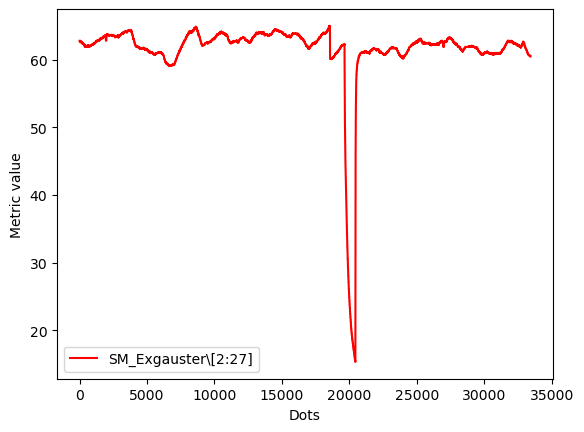

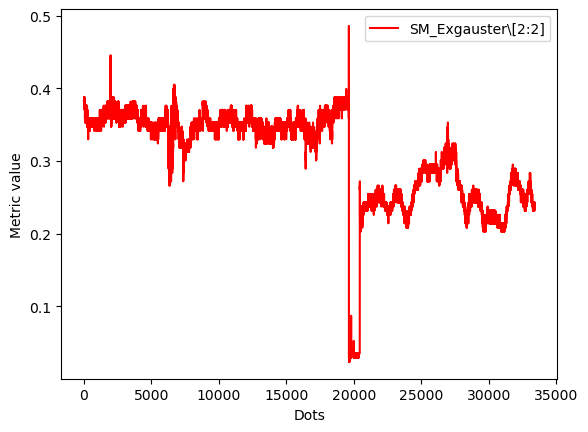

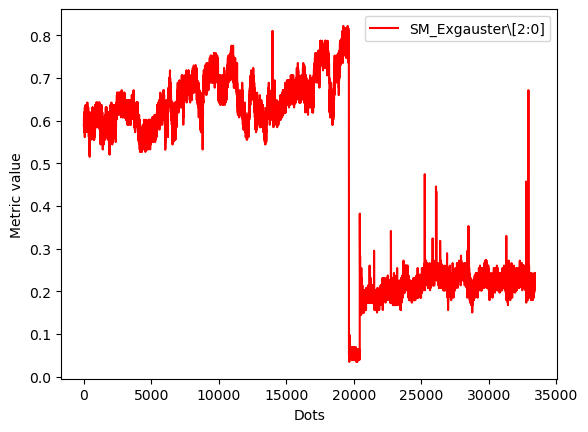

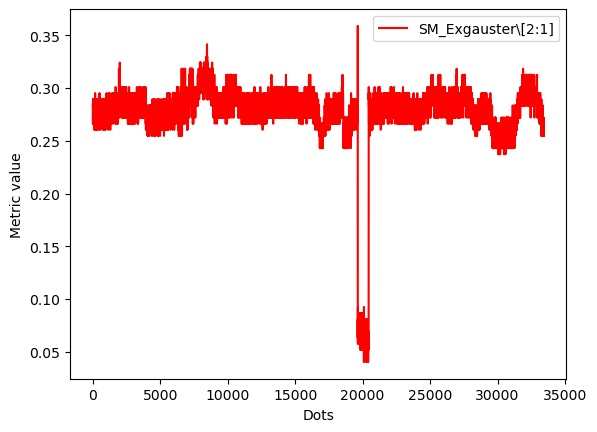

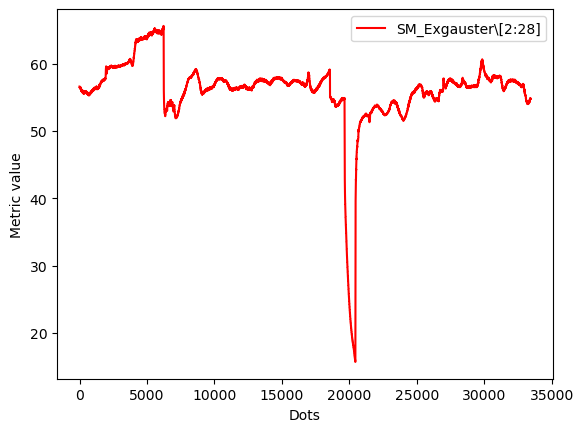

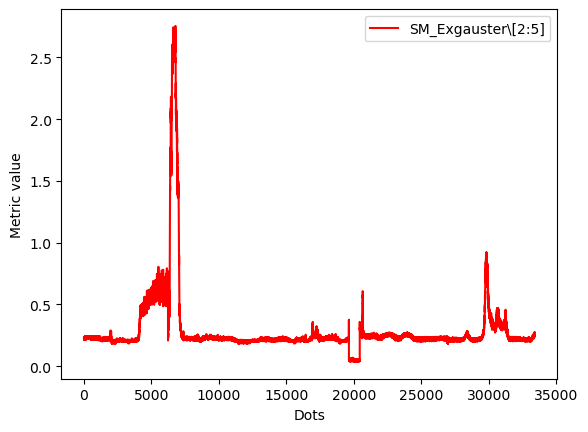

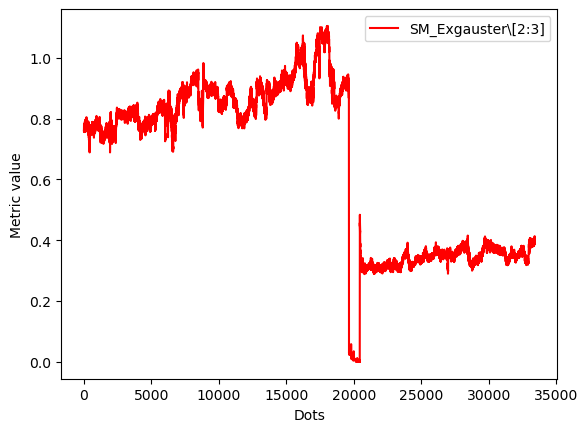

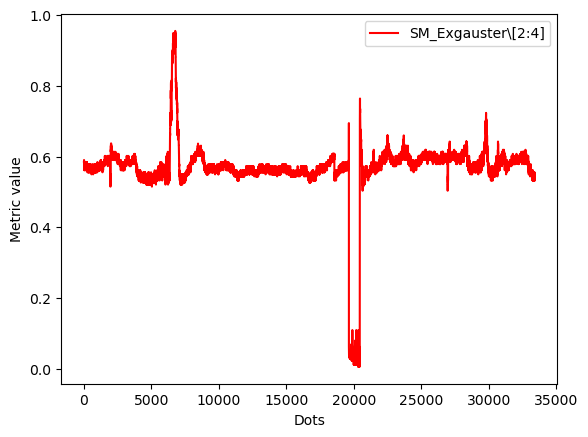

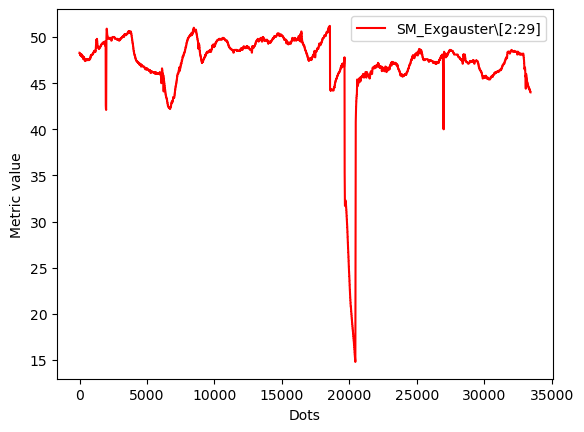

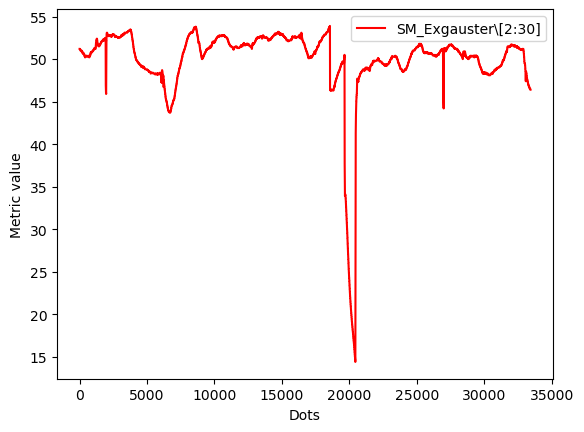

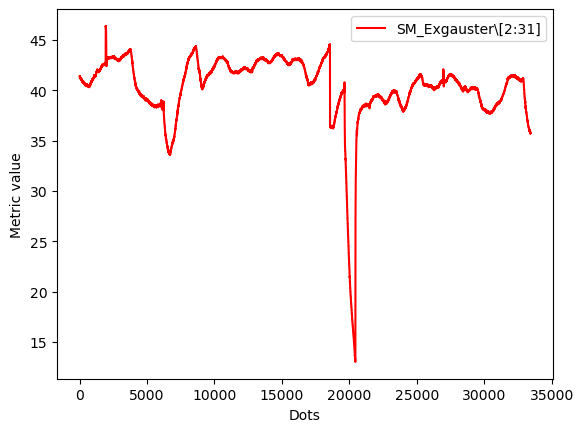

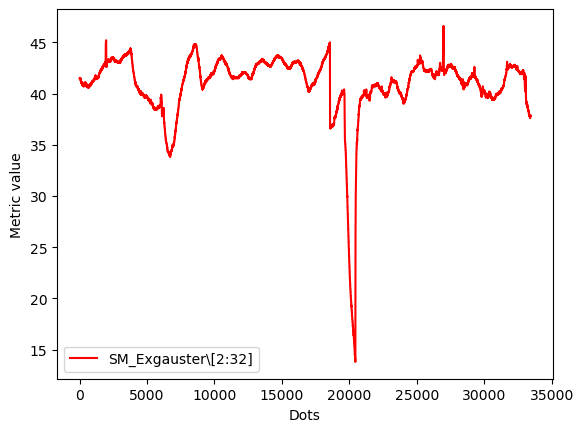

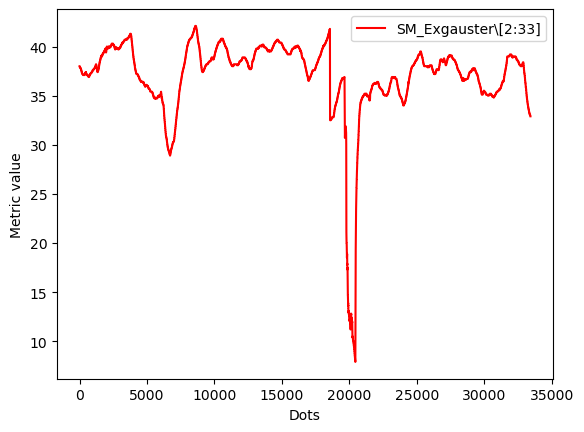

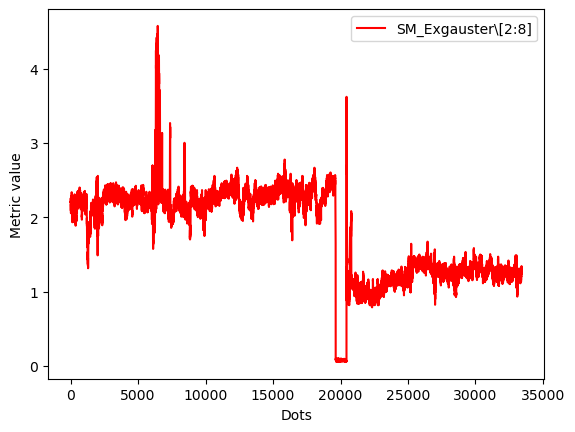

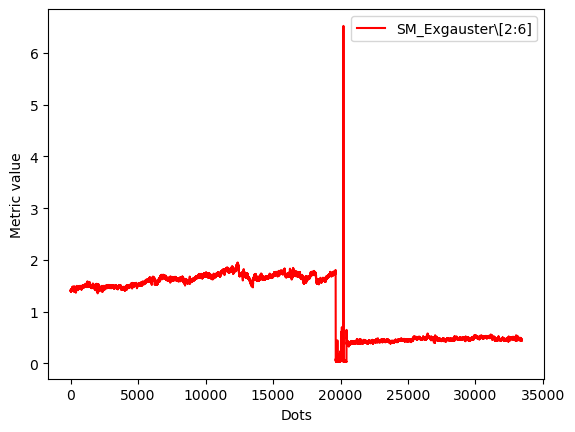

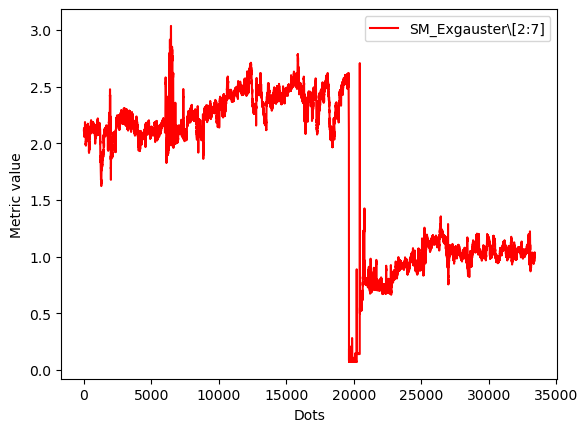

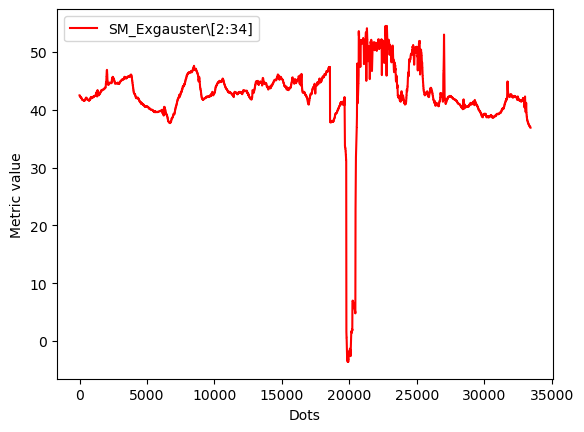

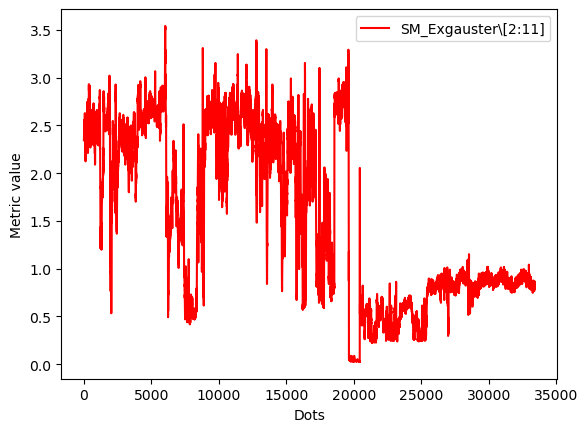

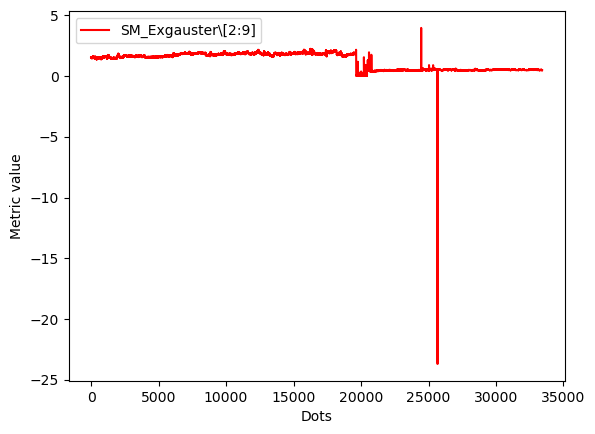

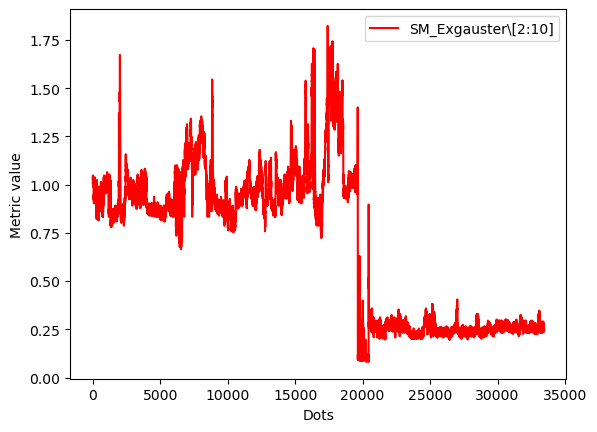

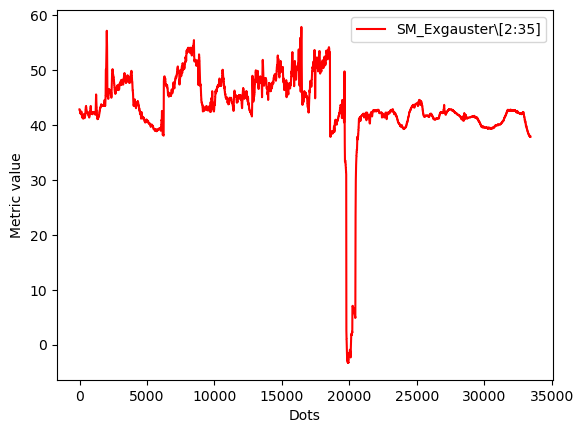

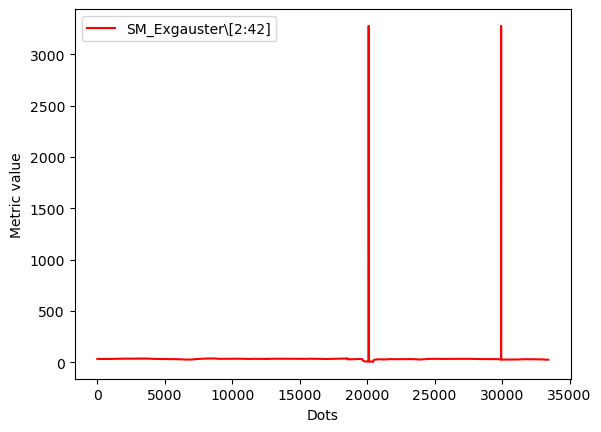

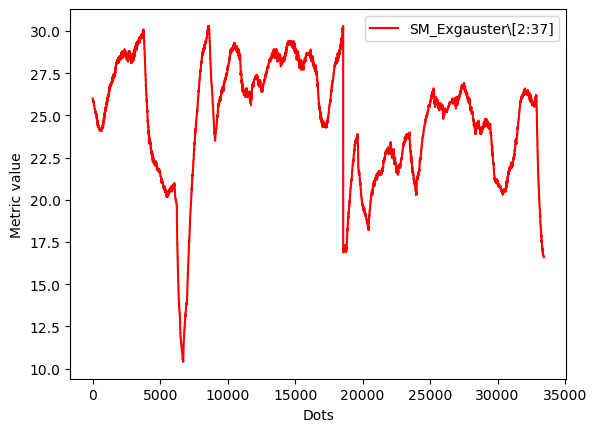

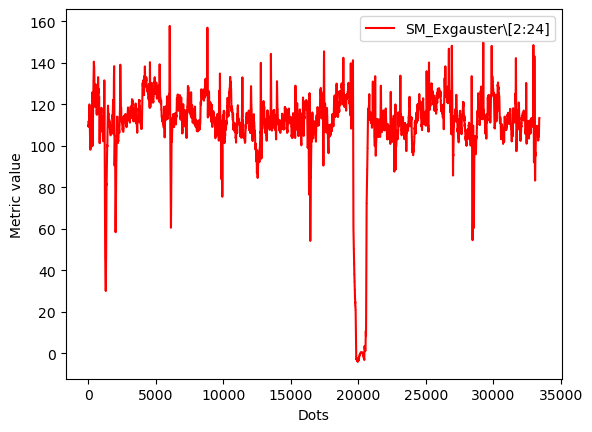

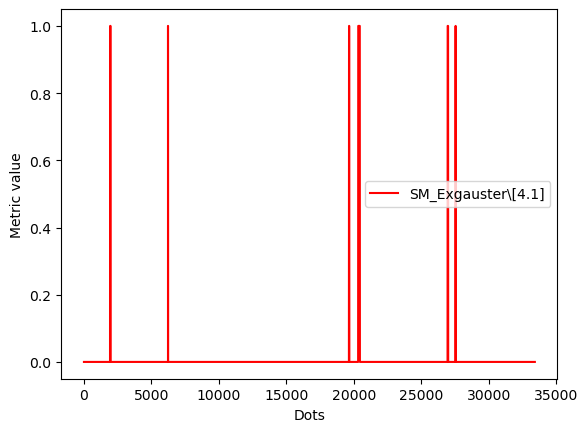

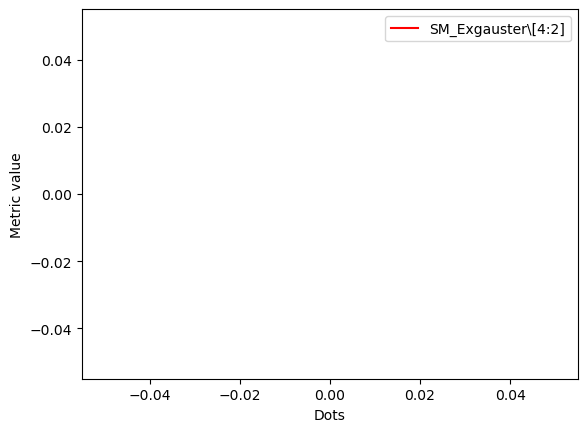

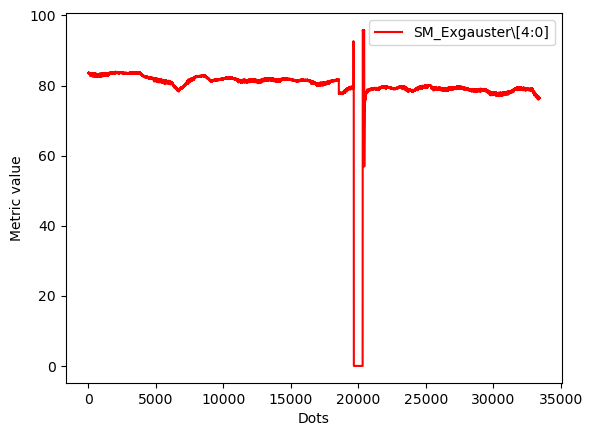

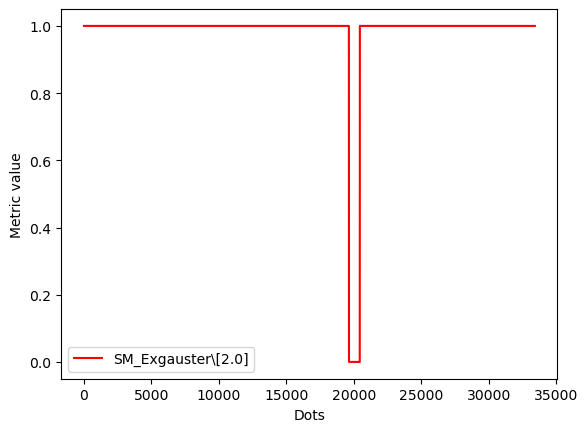

In [180]:
exg_1 = plot_data['0']
for metric_name, df in exg_1.items():
    plt.plot(df, color = 'red', label = metric_name)
    plt.xlabel('Dots')
    plt.ylabel('Metric value')
    plt.legend(loc = 'best')
    plt.show()

Заметим, что метрики некоторых деталей имеют определенный паттерн поведения:
1. Видно, что они растут со временем
2. После достижения некоторой критической точки и (видимо) замены детали, среднее значение резко уменьшается, но сохраняет тенденцию возрастания со временем

Такие метрики могут быть хорошими индикаторами необходимости остановки и обслуживания эксгаустера.
Узнав скорость возрастания метрики, мы сможем рассчитать время, через которое она вновь доберется до критической отметки.
Найдем коэфициенты углов наклона к горизонтальной плоскости средних этих метрик
(Заметим, также, что такой паттерн как раз встречается у метрик подшипников 7 и 8, отмеченных в ТЗ, что прибавляет нам уверенности в гипотезе)

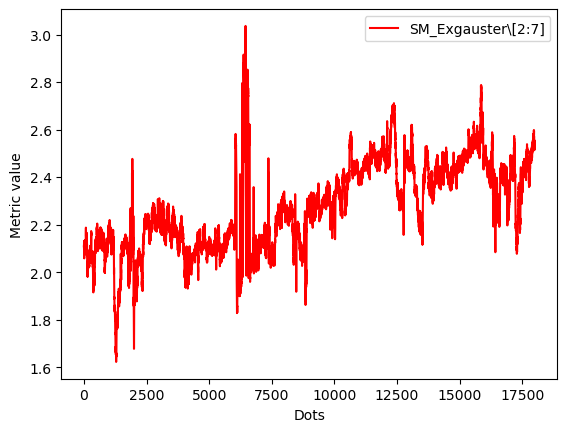

In [188]:
metric_name = "SM_Exgauster\\[2:7]" # VIBRATION_VERTICAL_SEVEN
ds = exg_1[metric_name][:18000]
plt.plot(ds, color = 'red', label = metric_name)
plt.xlabel('Dots')
plt.ylabel('Metric value')
plt.legend(loc = 'best')
plt.show()

In [189]:
from sklearn.linear_model import LinearRegression
X = np.arange(0, len(ds), 1).reshape(-1, 1)
y = np.array(ds["warning_min"]).reshape(-1, 1)
y[np.isnan(y)] = y[~np.isnan(y)].mean()
lin_reg = LinearRegression()
lin_reg.fit(X, y)


LinearRegression()

In [190]:
print(f'Coefficients: {lin_reg.coef_}')
print(f'Intercept: {lin_reg.intercept_}')
print(f'R^2 score: {lin_reg.score(X, y)}')

Coefficients: [[2.60824919e-05]]
Intercept: [2.03805118]
R^2 score: 0.5282823756368873


In [193]:
VIBRATION_VERTICAL_SEVEN = lin_reg.coef_

In [179]:
print(k1)# "SM_Exgauster\\[2:7]" VIBRATION_VERTICAL_SEVEN
print(k2)# "SM_Exgauster\\[2:6]" VIBRATION_HORIZONTAL_SEVEN
print(k3)# "SM_Exgauster\\[2:8]" VIBRATION_AXIAL_SEVEN
print(k4)# "SM_Exgauster\\[2:11]" VIBRATION_AXIAL_EIGHT

[[2.60824919e-05]]
[[1.71990613e-05]]
[[9.08204869e-06]]
[[4.2977256e-05]]


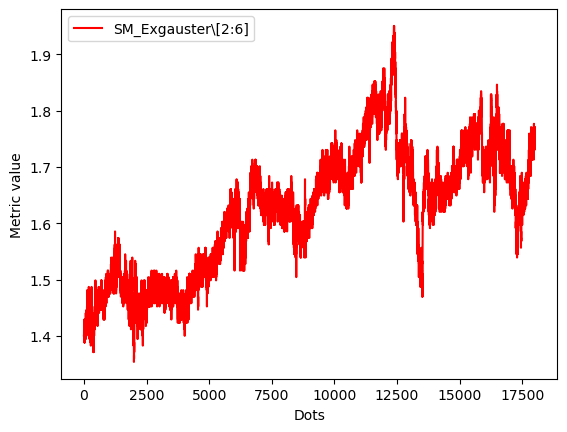

Coefficients: [[1.71990613e-05]]
Intercept: [1.46623821]
R^2 score: 0.6376572093675121


In [194]:
metric_name = "SM_Exgauster\\[2:6]" # VIBRATION_HORIZONTAL_SEVEN
ds = exg_1[metric_name][:18000]
plt.plot(ds, color = 'red', label = metric_name)
plt.xlabel('Dots')
plt.ylabel('Metric value')
plt.legend(loc = 'best')
plt.show()

from sklearn.linear_model import LinearRegression
X = np.arange(0, len(ds), 1).reshape(-1, 1)
y = np.array(ds["warning_min"]).reshape(-1, 1)
y[np.isnan(y)] = y[~np.isnan(y)].mean()
lin_reg = LinearRegression()
lin_reg.fit(X, y)


print(f'Coefficients: {lin_reg.coef_}')
print(f'Intercept: {lin_reg.intercept_}')
print(f'R^2 score: {lin_reg.score(X, y)}')

VIBRATION_HORIZONTAL_SEVEN = lin_reg.coef_

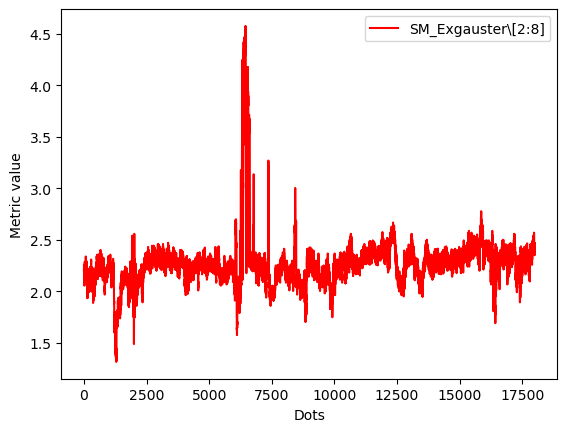

Coefficients: [[9.08204869e-06]]
Intercept: [2.18293131]
R^2 score: 0.03718550254084885


In [195]:
metric_name = "SM_Exgauster\\[2:8]" # VIBRATION_AXIAL_SEVEN
ds = exg_1[metric_name][:18000]
plt.plot(ds, color = 'red', label = metric_name)
plt.xlabel('Dots')
plt.ylabel('Metric value')
plt.legend(loc = 'best')
plt.show()

from sklearn.linear_model import LinearRegression
X = np.arange(0, len(ds), 1).reshape(-1, 1)
y = np.array(ds["warning_min"]).reshape(-1, 1)
y[np.isnan(y)] = y[~np.isnan(y)].mean()
lin_reg = LinearRegression()
lin_reg.fit(X, y)


print(f'Coefficients: {lin_reg.coef_}')
print(f'Intercept: {lin_reg.intercept_}')
print(f'R^2 score: {lin_reg.score(X, y)}')

VIBRATION_AXIAL_SEVEN = lin_reg.coef_

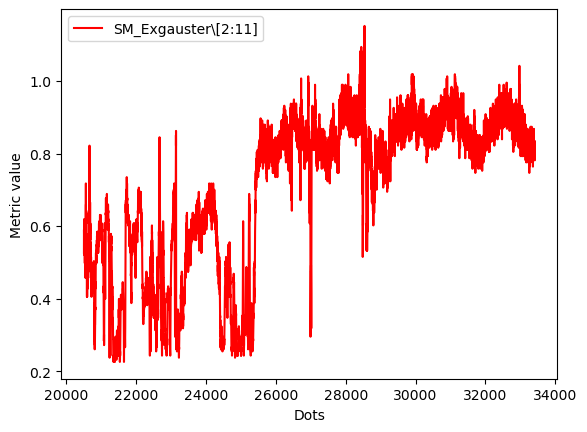

Coefficients: [[4.2977256e-05]]
Intercept: [0.42733508]
R^2 score: 0.5755331580154863


In [201]:
metric_name = "SM_Exgauster\\[2:11]" # VIBRATION_AXIAL_EIGHT
ds = exg_1[metric_name][20500:]
plt.plot(ds, color = 'red', label = metric_name)
plt.xlabel('Dots')
plt.ylabel('Metric value')
plt.legend(loc = 'best')
plt.show()

from sklearn.linear_model import LinearRegression
X = np.arange(0, len(ds), 1).reshape(-1, 1)
y = np.array(ds["warning_min"]).reshape(-1, 1)
y[np.isnan(y)] = y[~np.isnan(y)].mean()
lin_reg = LinearRegression()
lin_reg.fit(X, y)


print(f'Coefficients: {lin_reg.coef_}')
print(f'Intercept: {lin_reg.intercept_}')
print(f'R^2 score: {lin_reg.score(X, y)}')

VIBRATION_AXIAL_EIGHT = lin_reg.coef_

In [202]:
print(VIBRATION_VERTICAL_SEVEN)
print(VIBRATION_HORIZONTAL_SEVEN)
print(VIBRATION_AXIAL_SEVEN)
print(VIBRATION_AXIAL_EIGHT)

[[2.60824919e-05]]
[[1.71990613e-05]]
[[9.08204869e-06]]
[[4.2977256e-05]]


In [187]:
%history

import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima_model import ARIMA
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()
from typing import Optional
from pymongo import MongoClient

MONGO_HOST = '127.0.0.1'
MONGO_PORT = 27020
MONGO_USERNAME = 'admin'
MONGO_PASSWORD = 'admin'


class DayCollection:
    def __init__(self, collection):
        self.collection = collection

    def get_all(self):
        return self.collection.find({})


class MongoManager:
    __instance: Optional[MongoClient] = None
    DB_NAME = 'b'
    collection_by_day = 'records_{}_{}_{}'

    client: MongoClient = None

    def __init__(self):
        self.db = None

    def connect(self):
        self.client: MongoClient = MongoClient(
            MONGO_HOST, MONGO_PORT,
            username=MONGO_USERNAME,
            pas